Total valid pairs: 1161
Found 928 valid input-output pairs.
Found 233 valid input-output pairs.
Inspecting training data samples...


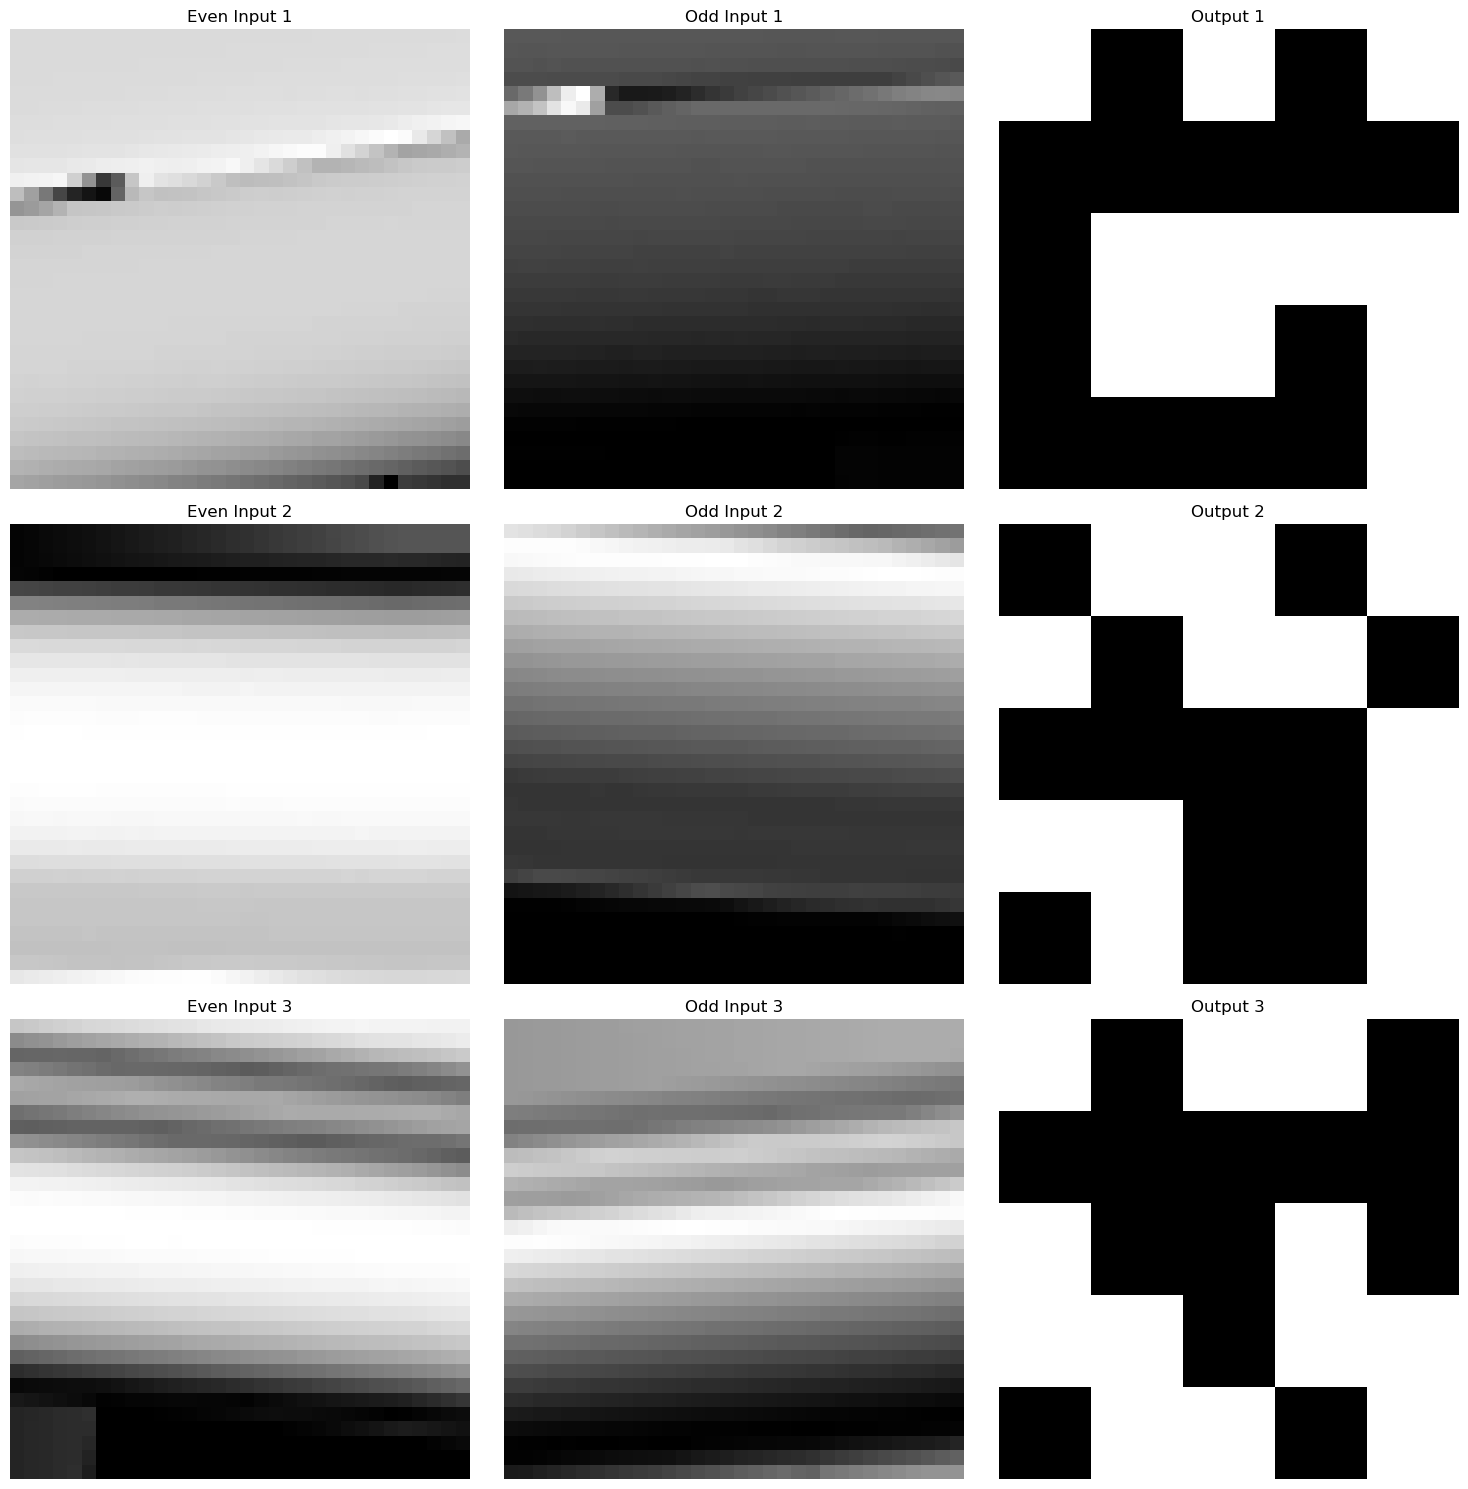

ValueError: All operation outputs must be tensors. Operation <BlockUniformityLayer name=block_uniformity_layer_1, built=True> returned a non-tensor. Non-tensor received: InputSpec(shape=(None, 50, 50, 1), ndim=4)

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator as KerasImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import warnings

# Suppress deprecation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Configuration
base_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data"
input_even_dir = os.path.join(base_dir, "gray_image", "even_images")
input_odd_dir = os.path.join(base_dir, "gray_image", "odd_images")
output_dir = os.path.join(base_dir, "matrix")
input_shape = (32, 32, 1)  # Grayscale images for even/odd inputs
output_shape = (50, 50, 1)  # Binary output
batch_size = 4  # Reduced to handle smaller dataset
learning_rate = 1e-5
epochs = 50
threshold = 0.5  # Threshold for binary output
block_size = 10  # 10x10 blocks in output

# Custom Layer to Enforce 10x10 Block Uniformity
class BlockUniformityLayer(layers.Layer):
    def __init__(self, block_size, threshold=0.5, **kwargs):
        super(BlockUniformityLayer, self).__init__(**kwargs)
        self.block_size = block_size
        self.threshold = threshold
    
    def call(self, inputs):
        x = layers.AveragePooling2D(
            pool_size=(self.block_size, self.block_size),
            strides=(self.block_size, self.block_size)
        )(inputs)
        x = tf.where(x > self.threshold, 1.0, 0.0)
        x = layers.UpSampling2D(
            size=(self.block_size, self.block_size),
            interpolation='nearest'
        )(x)
        return x
    
    def compute_output_spec(self, input_spec):
        input_shape = input_spec.shape
        output_shape = (
            input_shape[0],  # Batch size
            input_shape[1],  # Original height
            input_shape[2],  # Original width
            input_shape[3]   # Channels
        )
        return tf.keras.layers.InputSpec(shape=output_shape)
    
    def get_config(self):
        config = super().get_config()
        config.update({"block_size": self.block_size, "threshold": self.threshold})
        return config

# Model with Dual Inputs
def build_dual_input_model(input_shape, output_shape):
    input_even = layers.Input(shape=input_shape, name='even_input')
    input_odd = layers.Input(shape=input_shape, name='odd_input')
    
    # Process even input
    e1 = layers.Conv2D(64, 3, padding='same', activation='relu')(input_even)
    e1 = layers.MaxPooling2D(2)(e1)
    e2 = layers.Conv2D(128, 3, padding='same', activation='relu')(e1)
    
    # Process odd input
    o1 = layers.Conv2D(64, 3, padding='same', activation='relu')(input_odd)
    o1 = layers.MaxPooling2D(2)(o1)
    o2 = layers.Conv2D(128, 3, padding='same', activation='relu')(o1)
    
    # Merge branches
    merged = layers.Concatenate()([e2, o2])
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(merged)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(output_shape[-1], 3, padding='same', activation=None)(x)
    x = layers.Resizing(output_shape[0], output_shape[1])(x)
    
    # Enforce 10x10 block uniformity
    outputs = BlockUniformityLayer(block_size=block_size, threshold=threshold)(x)
    
    return models.Model(inputs=[input_even, input_odd], outputs=outputs)

# Data Generator for Dual Inputs with Augmentation
class ImageDataGenerator(Sequence):
    def __init__(self, input_even_dir, input_odd_dir, output_dir, batch_size, input_shape, output_shape, pairs=None, augment=False):
        self.input_even_dir = input_even_dir
        self.input_odd_dir = input_odd_dir
        self.output_dir = output_dir
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.augment = augment
        
        # Data augmentation
        self.augmentation = KerasImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
        ) if augment else None
        
        # Generate pairs
        self.pairs = []
        if pairs is None:
            missing_ids = []
            for filename in os.listdir(output_dir):
                if filename.endswith(".png"):
                    x = filename[:-4]
                    even_path = os.path.join(input_even_dir, f"{x}_even.png")
                    odd_path = os.path.join(input_odd_dir, f"{x}_odd.png")
                    output_path = os.path.join(output_dir, filename)
                    if os.path.exists(even_path) and os.path.exists(odd_path):
                        self.pairs.append((even_path, odd_path, output_path))
                    else:
                        missing_ids.append(x)
            if missing_ids:
                print(f"Warning: Missing input files for {len(missing_ids)} IDs: {', '.join(missing_ids[:10])}{', ...' if len(missing_ids) > 10 else ''}")
            if not self.pairs:
                raise ValueError("No valid input-output pairs found.")
        else:
            self.pairs = pairs
        
        # Shuffle pairs
        np.random.shuffle(self.pairs)
        print(f"Found {len(self.pairs)} valid input-output pairs.")
    
    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_pairs = self.pairs[idx * self.batch_size: (idx + 1) * self.batch_size]
        
        batch_even = np.zeros((len(batch_pairs), *self.input_shape))
        batch_odd = np.zeros((len(batch_pairs), *self.input_shape))
        batch_output = np.zeros((len(batch_pairs), *self.output_shape))
        
        for i, (even_path, odd_path, output_path) in enumerate(batch_pairs):
            try:
                # Load even input
                even_img = Image.open(even_path).convert('L')
                even_img = even_img.resize((self.input_shape[1], self.input_shape[0]))
                even_img = np.array(even_img) / 255.0
                even_img = np.expand_dims(even_img, axis=-1)
                
                # Load odd input
                odd_img = Image.open(odd_path).convert('L')
                odd_img = odd_img.resize((self.input_shape[1], self.input_shape[0]))
                odd_img = np.array(odd_img) / 255.0
                odd_img = np.expand_dims(odd_img, axis=-1)
                
                # Apply augmentation
                if self.augment:
                    even_img = self.augmentation.random_transform(even_img)
                    odd_img = self.augmentation.random_transform(odd_img)
                
                batch_even[i] = even_img
                batch_odd[i] = odd_img
                
                # Load and preprocess output
                output_img = Image.open(output_path).convert('L')
                output_img = output_img.resize((self.output_shape[1], self.output_shape[0]))
                output_img = np.array(output_img)
                output_img = (output_img > 128).astype(np.float32)  # Binarize
                blocks = output_img.reshape(5, block_size, 5, block_size)
                blocks = blocks.mean(axis=(1, 3))
                blocks = (blocks > 0.5).astype(np.float32)
                output_img = np.repeat(np.repeat(blocks, block_size, axis=0), block_size, axis=1)
                batch_output[i] = np.expand_dims(output_img, axis=-1)
            except Exception as e:
                print(f"Error processing pair {even_path}, {odd_path}, {output_path}: {str(e)}")
                continue
        
        return [batch_even, batch_odd], batch_output

# Inspect data samples
def inspect_data(generator, num_samples=3):
    [even_inputs, odd_inputs], outputs = generator[0]
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(even_inputs))):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(even_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Even Input {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(odd_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Odd Input {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(outputs[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Output {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Split data into training and validation
all_pairs = []
missing_ids = []
for filename in os.listdir(output_dir):
    if filename.endswith(".png"):
        x = filename[:-4]
        even_path = os.path.join(input_even_dir, f"{x}_even.png")
        odd_path = os.path.join(input_odd_dir, f"{x}_odd.png")
        output_path = os.path.join(output_dir, filename)
        if os.path.exists(even_path) and os.path.exists(odd_path):
            all_pairs.append((even_path, odd_path, output_path))
        else:
            missing_ids.append(x)
if missing_ids:
    print(f"Warning: Missing input files for {len(missing_ids)} IDs: {', '.join(missing_ids[:10])}{', ...' if len(missing_ids) > 10 else ''}")
if not all_pairs:
    raise ValueError("No valid input-output pairs found.")
print(f"Total valid pairs: {len(all_pairs)}")

np.random.shuffle(all_pairs)
train_size = int(0.8 * len(all_pairs))
train_pairs = all_pairs[:train_size]
val_pairs = all_pairs[train_size:]

# Create data generators
train_generator = ImageDataGenerator(
    input_even_dir, 
    input_odd_dir, 
    output_dir, 
    batch_size, 
    input_shape, 
    output_shape,
    pairs=train_pairs,
    augment=True
)
val_generator = ImageDataGenerator(
    input_even_dir, 
    input_odd_dir, 
    output_dir, 
    batch_size, 
    input_shape, 
    output_shape,
    pairs=val_pairs,
    augment=False
)

# Inspect data before training
print("Inspecting training data samples...")
inspect_data(train_generator, num_samples=3)

# Build and compile the model
model = build_dual_input_model(input_shape, output_shape)
model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Add callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        save_best_only=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# Save the final model
model.save("image_translation_model_final.keras")

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize predictions
def visualize_predictions(model, generator, num_samples=3):
    [even_inputs, odd_inputs], true_outputs = generator[0]
    predictions = model.predict([even_inputs, odd_inputs])
    
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(even_inputs))):
        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(even_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Even Input {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(odd_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Odd Input {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(true_outputs[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Ground Truth {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 4, i * 4 + 4)
        plt.imshow(predictions[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Binary Prediction {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    print("Unique values in predictions:", np.unique(predictions.round()))

# Evaluate model
def evaluate_model(model, generator):
    loss, accuracy = model.evaluate(generator, verbose=0)
    print(f"Binary Cross-Entropy Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    [even_inputs, odd_inputs], true_outputs = generator[0]
    preds = model.predict([even_inputs, odd_inputs])
    
    try:
        true_tensor = tf.convert_to_tensor(true_outputs, dtype=tf.float64)
        pred_tensor = tf.convert_to_tensor(preds, dtype=tf.float64)
        ssim = tf.image.ssim(true_tensor, pred_tensor, max_val=1.0).numpy().mean()
        psnr = tf.image.psnr(true_tensor, pred_tensor, max_val=1.0).numpy().mean()
        print(f"Structural Similarity (SSIM): {ssim:.4f}")
        print(f"Peak SNR (PSNR): {psnr:.2f} dB")
        
        return {'loss': loss, 'accuracy': accuracy, 'ssim': ssim, 'psnr': psnr}
    except Exception as e:
        print(f"Error calculating quality metrics: {str(e)}")
        return {'loss': loss, 'accuracy': accuracy, 'ssim': None, 'psnr': None}

# Run visualization and evaluation
visualize_predictions(model, val_generator, num_samples=3)
metrics = evaluate_model(model, val_generator)

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator as KerasImageDataGenerator
from tensorflow.keras import backend as K
from PIL import Image
import matplotlib.pyplot as plt
import warnings

# Suppress deprecation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Configuration
base_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data"
input_even_dir = os.path.join(base_dir, "gray_image", "even_images")
input_odd_dir = os.path.join(base_dir, "gray_image", "odd_images")
output_dir = os.path.join(base_dir, "matrix")
input_shape = (32, 32, 1)  # Grayscale images for even/odd inputs
output_shape = (50, 50, 1)  # Binary output
batch_size = 4
learning_rate = 1e-5
epochs = 50
threshold = 0.5
block_size = 10

# Custom Layer to Enforce 10x10 Block Uniformity
class BlockUniformityLayer(layers.Layer):
    def __init__(self, block_size, threshold=0.5, **kwargs):
        super(BlockUniformityLayer, self).__init__(**kwargs)
        self.block_size = block_size
        self.threshold = threshold
    
    def call(self, inputs):
        x = layers.AveragePooling2D(
            pool_size=(self.block_size, self.block_size),
            strides=(self.block_size, self.block_size)
        )(inputs)
        x = tf.where(x > self.threshold, 1.0, 0.0)
        x = layers.UpSampling2D(
            size=(self.block_size, self.block_size),
            interpolation='nearest'
        )(x)
        return x
    
    def compute_output_spec(self, input_spec):
        return tf.keras.KerasTensor(
            shape=input_spec.shape,
            dtype=input_spec.dtype
        )
    
    def get_config(self):
        config = super().get_config()
        config.update({"block_size": self.block_size, "threshold": self.threshold})
        return config

# Model with Dual Inputs
def build_dual_input_model(input_shape, output_shape):
    input_even = layers.Input(shape=input_shape, name='even_input')
    input_odd = layers.Input(shape=input_shape, name='odd_input')
    
    # Process even input
    e1 = layers.Conv2D(64, 3, padding='same', activation='relu')(input_even)
    e1 = layers.MaxPooling2D(2)(e1)
    e2 = layers.Conv2D(128, 3, padding='same', activation='relu')(e1)
    
    # Process odd input
    o1 = layers.Conv2D(64, 3, padding='same', activation='relu')(input_odd)
    o1 = layers.MaxPooling2D(2)(o1)
    o2 = layers.Conv2D(128, 3, padding='same', activation='relu')(o1)
    
    # Merge branches
    merged = layers.Concatenate()([e2, o2])
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(merged)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(output_shape[-1], 3, padding='same', activation=None)(x)
    x = layers.Resizing(output_shape[0], output_shape[1])(x)
    
    # Enforce 10x10 block uniformity
    outputs = BlockUniformityLayer(block_size=block_size, threshold=threshold)(x)
    
    return models.Model(inputs=[input_even, input_odd], outputs=outputs)

# Data Generator for Dual Inputs with Augmentation
class ImageDataGenerator(Sequence):
    def __init__(self, input_even_dir, input_odd_dir, output_dir, batch_size, input_shape, output_shape, pairs=None, augment=False, **kwargs):
        super().__init__(**kwargs)  # Fix PyDataset warning
        self.input_even_dir = input_even_dir
        self.input_odd_dir = input_odd_dir
        self.output_dir = output_dir
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.augment = augment
        
        # Data augmentation
        self.augmentation = KerasImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
        ) if augment else None
        
        # Generate pairs
        self.pairs = []
        if pairs is None:
            missing_ids = []
            output_files = [f for f in os.listdir(output_dir) if f.endswith(".png")]
            for filename in output_files:
                x = filename[:-4]
                even_path = os.path.join(input_even_dir, f"{x}_even.png")
                odd_path = os.path.join(input_odd_dir, f"{x}_odd.png")
                output_path = os.path.join(output_dir, filename)
                if os.path.exists(even_path) and os.path.exists(odd_path):
                    self.pairs.append((even_path, odd_path, output_path))
                else:
                    missing_ids.append(x)
            if missing_ids:
                print(f"Warning: Missing input files for {len(missing_ids)} IDs: {', '.join(missing_ids[:10])}{', ...' if len(missing_ids) > 10 else ''}")
            if not self.pairs:
                raise ValueError("No valid input-output pairs found.")
        else:
            self.pairs = pairs
        
        # Shuffle pairs
        np.random.shuffle(self.pairs)
        print(f"Found {len(self.pairs)} valid input-output pairs.")
    
    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_pairs = self.pairs[idx * self.batch_size: (idx + 1) * self.batch_size]
        
        batch_even = np.zeros((len(batch_pairs), *self.input_shape))
        batch_odd = np.zeros((len(batch_pairs), *self.input_shape))
        batch_output = np.zeros((len(batch_pairs), *self.output_shape))
        
        for i, (even_path, odd_path, output_path) in enumerate(batch_pairs):
            try:
                # Load even input
                even_img = Image.open(even_path).convert('L')
                even_img = even_img.resize((self.input_shape[1], self.input_shape[0]))
                even_img = np.array(even_img) / 255.0
                even_img = np.expand_dims(even_img, axis=-1)
                
                # Load odd input
                odd_img = Image.open(odd_path).convert('L')
                odd_img = odd_img.resize((self.input_shape[1], self.input_shape[0]))
                odd_img = np.array(odd_img) / 255.0
                odd_img = np.expand_dims(odd_img, axis=-1)
                
                # Apply augmentation
                if self.augment:
                    even_img = self.augmentation.random_transform(even_img)
                    odd_img = self.augmentation.random_transform(odd_img)
                
                batch_even[i] = even_img
                batch_odd[i] = odd_img
                
                # Load and preprocess output
                output_img = Image.open(output_path).convert('L')
                output_img = output_img.resize((self.output_shape[1], self.output_shape[0]))
                output_img = np.array(output_img)
                output_img = (output_img > 128).astype(np.float32)  # Binarize
                blocks = output_img.reshape(5, block_size, 5, block_size)
                blocks = blocks.mean(axis=(1, 3))
                blocks = (blocks > 0.5).astype(np.float32)
                output_img = np.repeat(np.repeat(blocks, block_size, axis=0), block_size, axis=1)
                batch_output[i] = np.expand_dims(output_img, axis=-1)
            except Exception as e:
                print(f"Error processing pair {even_path}, {odd_path}, {output_path}: {str(e)}")
                continue
        
        return [batch_even, batch_odd], batch_output

# Convert generator to tf.data.Dataset
def create_dataset(generator):
    output_signature = (
        [
            tf.TensorSpec(shape=(None, *generator.input_shape), dtype=tf.float32),
            tf.TensorSpec(shape=(None, *generator.input_shape), dtype=tf.float32)
        ],
        tf.TensorSpec(shape=(None, *generator.output_shape), dtype=tf.float32)
    )
    
    def gen():
        for data in generator:
            yield data
    
    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=output_signature
    )
    return dataset.prefetch(tf.data.AUTOTUNE)

# Inspect data samples
def inspect_data(generator, num_samples=3):
    [even_inputs, odd_inputs], outputs = generator[0]
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(even_inputs))):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(even_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Even Input {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(odd_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Odd Input {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(outputs[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Output {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# File count check
def check_file_counts():
    output_files = len([f for f in os.listdir(output_dir) if f.endswith('.png')])
    even_files = len([f for f in os.listdir(input_even_dir) if f.endswith('_even.png')])
    odd_files = len([f for f in os.listdir(input_odd_dir) if f.endswith('_odd.png')])
    print(f"Total output files: {output_files}")
    print(f"Total even input files: {even_files}")
    print(f"Total odd input files: {odd_files}")

# Split data into training and validation
check_file_counts()
all_pairs = []
missing_ids = []
output_files = [f for f in os.listdir(output_dir) if f.endswith(".png")]
for filename in output_files:
    x = filename[:-4]
    even_path = os.path.join(input_even_dir, f"{x}_even.png")
    odd_path = os.path.join(input_odd_dir, f"{x}_odd.png")
    output_path = os.path.join(output_dir, filename)
    if os.path.exists(even_path) and os.path.exists(odd_path):
        all_pairs.append((even_path, odd_path, output_path))
    else:
        missing_ids.append(x)
if missing_ids:
    print(f"Warning: Missing input files for {len(missing_ids)} IDs: {', '.join(missing_ids[:10])}{', ...' if len(missing_ids) > 10 else ''}")
if not all_pairs:
    raise ValueError("No valid input-output pairs found.")
print(f"Total valid pairs: {len(all_pairs)}")

np.random.shuffle(all_pairs)
train_size = int(0.8 * len(all_pairs))
train_pairs = all_pairs[:train_size]
val_pairs = all_pairs[train_size:]

# Create data generators
train_generator = ImageDataGenerator(
    input_even_dir, 
    input_odd_dir, 
    output_dir, 
    batch_size, 
    input_shape, 
    output_shape,
    pairs=train_pairs,
    augment=True
)
val_generator = ImageDataGenerator(
    input_even_dir, 
    input_odd_dir, 
    output_dir, 
    batch_size, 
    input_shape, 
    output_shape,
    pairs=val_pairs,
    augment=False
)

# Convert to tf.data.Dataset
train_dataset = create_dataset(train_generator)
val_dataset = create_dataset(val_generator)

# Inspect data before training
print("Inspecting training data samples...")
inspect_data(train_generator, num_samples=3)

# Build and compile the model
model = build_dual_input_model(input_shape, output_shape)
model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Add callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        save_best_only=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# Save the final model
model.save("image_translation_model_final.keras")

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize predictions
def visualize_predictions(model, generator, num_samples=3):
    [even_inputs, odd_inputs], true_outputs = generator[0]
    predictions = model.predict([even_inputs, odd_inputs])
    
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(even_inputs))):
        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(even_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Even Input {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(odd_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Odd Input {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(true_outputs[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Ground Truth {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 4, i * 4 + 4)
        plt.imshow(predictions[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Binary Prediction {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    print("Unique values in predictions:", np.unique(predictions.round()))

# Evaluate model
def evaluate_model(model, generator):
    loss, accuracy = model.evaluate(generator, verbose=0)
    print(f"Binary Cross-Entropy Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    [even_inputs, odd_inputs], true_outputs = generator[0]
    preds = model.predict([even_inputs, odd_inputs])
    
    try:
        true_tensor = tf.convert_to_tensor(true_outputs, dtype=tf.float64)
        pred_tensor = tf.convert_to_tensor(preds, dtype=tf.float64)
        ssim = tf.image.ssim(true_tensor, pred_tensor, max_val=1.0).numpy().mean()
        psnr = tf.image.psnr(true_tensor, pred_tensor, max_val=1.0).numpy().mean()
        print(f"Structural Similarity (SSIM): {ssim:.4f}")
        print(f"Peak SNR (PSNR): {psnr:.2f} dB")
        
        return {'loss': loss, 'accuracy': accuracy, 'ssim': ssim, 'psnr': psnr}
    except Exception as e:
        print(f"Error calculating quality metrics: {str(e)}")
        return {'loss': loss, 'accuracy': accuracy, 'ssim': None, 'psnr': None}

# Run visualization and evaluation
visualize_predictions(model, val_generator, num_samples=3)
metrics = evaluate_model(model, val_generator)

Total output files: 1500
Total even input files: 1161
Total odd input files: 1161
Total valid pairs: 1161
Found 928 valid input-output pairs.
Found 233 valid input-output pairs.


TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.


Total output files: 1500
Total even input files: 1161
Total odd input files: 1161
Total valid pairs: 1161
Found 928 valid input-output pairs.
Found 233 valid input-output pairs.
Inspecting training data samples...


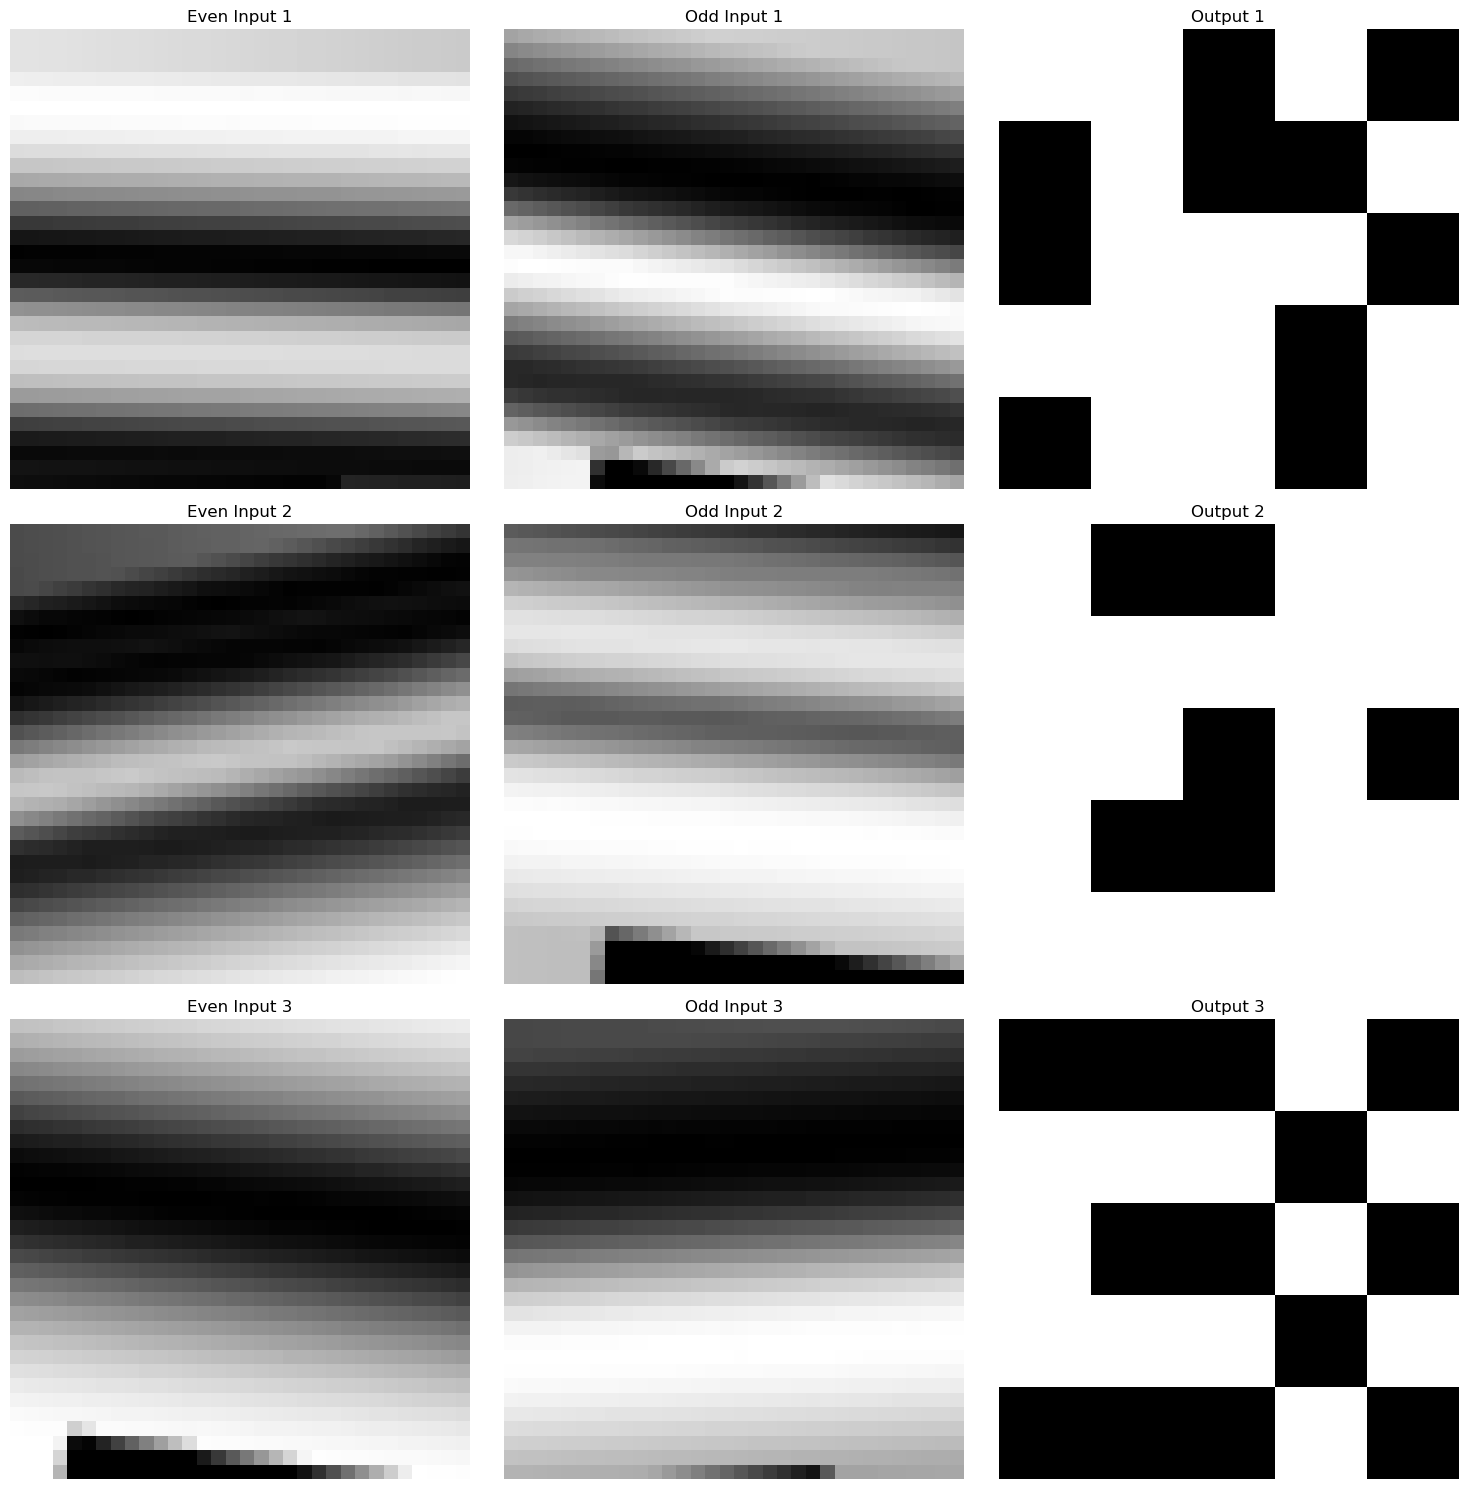

Epoch 1/50


ValueError: No gradients provided for any variable.

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator as KerasImageDataGenerator
from tensorflow.keras import backend as K
from PIL import Image
import matplotlib.pyplot as plt
import warnings

# Suppress deprecation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Configuration
base_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data"
input_even_dir = os.path.join(base_dir, "gray_image", "even_images")
input_odd_dir = os.path.join(base_dir, "gray_image", "odd_images")
output_dir = os.path.join(base_dir, "matrix")
input_shape = (32, 32, 1)  # Grayscale images for even/odd inputs
output_shape = (50, 50, 1)  # Binary output
batch_size = 4
learning_rate = 1e-5
epochs = 50
threshold = 0.5
block_size = 10

# Custom Layer to Enforce 10x10 Block Uniformity
class BlockUniformityLayer(layers.Layer):
    def __init__(self, block_size, threshold=0.5, **kwargs):
        super(BlockUniformityLayer, self).__init__(**kwargs)
        self.block_size = block_size
        self.threshold = threshold
    
    def call(self, inputs):
        x = layers.AveragePooling2D(
            pool_size=(self.block_size, self.block_size),
            strides=(self.block_size, self.block_size)
        )(inputs)
        x = tf.where(x > self.threshold, 1.0, 0.0)
        x = layers.UpSampling2D(
            size=(self.block_size, self.block_size),
            interpolation='nearest'
        )(x)
        return x
    
    def compute_output_spec(self, input_spec):
        return tf.keras.KerasTensor(
            shape=input_spec.shape,
            dtype=input_spec.dtype
        )
    
    def get_config(self):
        config = super().get_config()
        config.update({"block_size": self.block_size, "threshold": self.threshold})
        return config

# Model with Dual Inputs
def build_dual_input_model(input_shape, output_shape):
    input_even = layers.Input(shape=input_shape, name='even_input')
    input_odd = layers.Input(shape=input_shape, name='odd_input')
    
    # Process even input
    e1 = layers.Conv2D(64, 3, padding='same', activation='relu')(input_even)
    e1 = layers.MaxPooling2D(2)(e1)
    e2 = layers.Conv2D(128, 3, padding='same', activation='relu')(e1)
    
    # Process odd input
    o1 = layers.Conv2D(64, 3, padding='same', activation='relu')(input_odd)
    o1 = layers.MaxPooling2D(2)(o1)
    o2 = layers.Conv2D(128, 3, padding='same', activation='relu')(o1)
    
    # Merge branches
    merged = layers.Concatenate()([e2, o2])
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(merged)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(output_shape[-1], 3, padding='same', activation=None)(x)
    x = layers.Resizing(output_shape[0], output_shape[1])(x)
    
    # Enforce 10x10 block uniformity
    outputs = BlockUniformityLayer(block_size=block_size, threshold=threshold)(x)
    
    return models.Model(inputs=[input_even, input_odd], outputs=outputs)

# Data Generator for Dual Inputs with Augmentation
class ImageDataGenerator(Sequence):
    def __init__(self, input_even_dir, input_odd_dir, output_dir, batch_size, input_shape, output_shape, pairs=None, augment=False, **kwargs):
        super().__init__(**kwargs)
        self.input_even_dir = input_even_dir
        self.input_odd_dir = input_odd_dir
        self.output_dir = output_dir
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.augment = augment
        
        # Data augmentation
        self.augmentation = KerasImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
        ) if augment else None
        
        # Generate pairs
        self.pairs = []
        if pairs is None:
            missing_ids = []
            output_files = [f for f in os.listdir(output_dir) if f.endswith(".png")]
            for filename in output_files:
                x = filename[:-4]
                even_path = os.path.join(input_even_dir, f"{x}_even.png")
                odd_path = os.path.join(input_odd_dir, f"{x}_odd.png")
                output_path = os.path.join(output_dir, filename)
                if os.path.exists(even_path) and os.path.exists(odd_path):
                    self.pairs.append((even_path, odd_path, output_path))
                else:
                    missing_ids.append(x)
            if missing_ids:
                print(f"Warning: Missing input files for {len(missing_ids)} IDs: {', '.join(missing_ids[:10])}{', ...' if len(missing_ids) > 10 else ''}")
            if not self.pairs:
                raise ValueError("No valid input-output pairs found.")
        else:
            self.pairs = pairs
        
        # Shuffle pairs
        np.random.shuffle(self.pairs)
        print(f"Found {len(self.pairs)} valid input-output pairs.")
    
    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_pairs = self.pairs[idx * self.batch_size: (idx + 1) * self.batch_size]
        
        batch_even = np.zeros((len(batch_pairs), *self.input_shape))
        batch_odd = np.zeros((len(batch_pairs), *self.input_shape))
        batch_output = np.zeros((len(batch_pairs), *self.output_shape))
        
        for i, (even_path, odd_path, output_path) in enumerate(batch_pairs):
            try:
                # Load even input
                even_img = Image.open(even_path).convert('L')
                even_img = even_img.resize((self.input_shape[1], self.input_shape[0]))
                even_img = np.array(even_img) / 255.0
                even_img = np.expand_dims(even_img, axis=-1)
                
                # Load odd input
                odd_img = Image.open(odd_path).convert('L')
                odd_img = odd_img.resize((self.input_shape[1], self.input_shape[0]))
                odd_img = np.array(odd_img) / 255.0
                odd_img = np.expand_dims(odd_img, axis=-1)
                
                # Apply augmentation
                if self.augment:
                    even_img = self.augmentation.random_transform(even_img)
                    odd_img = self.augmentation.random_transform(odd_img)
                
                batch_even[i] = even_img
                batch_odd[i] = odd_img
                
                # Load and preprocess output
                output_img = Image.open(output_path).convert('L')
                output_img = output_img.resize((self.output_shape[1], self.output_shape[0]))
                output_img = np.array(output_img)
                output_img = (output_img > 128).astype(np.float32)  # Binarize
                blocks = output_img.reshape(5, block_size, 5, block_size)
                blocks = blocks.mean(axis=(1, 3))
                blocks = (blocks > 0.5).astype(np.float32)
                output_img = np.repeat(np.repeat(blocks, block_size, axis=0), block_size, axis=1)
                batch_output[i] = np.expand_dims(output_img, axis=-1)
            except Exception as e:
                print(f"Error processing pair {even_path}, {odd_path}, {output_path}: {str(e)}")
                continue
        
        return [batch_even, batch_odd], batch_output

# Convert generator to tf.data.Dataset
def create_dataset(generator):
    output_signature = (
        (
            tf.TensorSpec(shape=(None, *generator.input_shape), dtype=tf.float32),
            tf.TensorSpec(shape=(None, *generator.input_shape), dtype=tf.float32)
        ),
        tf.TensorSpec(shape=(None, *generator.output_shape), dtype=tf.float32)
    )
    
    def gen():
        for data in generator:
            yield data
    
    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=output_signature
    )
    return dataset.prefetch(tf.data.AUTOTUNE)

# Inspect data samples
def inspect_data(generator, num_samples=3):
    [even_inputs, odd_inputs], outputs = generator[0]
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(even_inputs))):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(even_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Even Input {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(odd_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Odd Input {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(outputs[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Output {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# File count check
def check_file_counts():
    output_files = len([f for f in os.listdir(output_dir) if f.endswith('.png')])
    even_files = len([f for f in os.listdir(input_even_dir) if f.endswith('_even.png')])
    odd_files = len([f for f in os.listdir(input_odd_dir) if f.endswith('_odd.png')])
    print(f"Total output files: {output_files}")
    print(f"Total even input files: {even_files}")
    print(f"Total odd input files: {odd_files}")

# Split data into training and validation
check_file_counts()
all_pairs = []
missing_ids = []
output_files = [f for f in os.listdir(output_dir) if f.endswith(".png")]
for filename in output_files:
    x = filename[:-4]
    even_path = os.path.join(input_even_dir, f"{x}_even.png")
    odd_path = os.path.join(input_odd_dir, f"{x}_odd.png")
    output_path = os.path.join(output_dir, filename)
    if os.path.exists(even_path) and os.path.exists(odd_path):
        all_pairs.append((even_path, odd_path, output_path))
    else:
        missing_ids.append(x)
if missing_ids:
    print(f"Warning: Missing input files for {len(missing_ids)} IDs: {', '.join(missing_ids[:10])}{', ...' if len(missing_ids) > 10 else ''}")
if not all_pairs:
    raise ValueError("No valid input-output pairs found.")
print(f"Total valid pairs: {len(all_pairs)}")

np.random.shuffle(all_pairs)
train_size = int(0.8 * len(all_pairs))
train_pairs = all_pairs[:train_size]
val_pairs = all_pairs[train_size:]

# Create data generators
train_generator = ImageDataGenerator(
    input_even_dir, 
    input_odd_dir, 
    output_dir, 
    batch_size, 
    input_shape, 
    output_shape,
    pairs=train_pairs,
    augment=True
)
val_generator = ImageDataGenerator(
    input_even_dir, 
    input_odd_dir, 
    output_dir, 
    batch_size, 
    input_shape, 
    output_shape,
    pairs=val_pairs,
    augment=False
)

# Convert to tf.data.Dataset
train_dataset = create_dataset(train_generator)
val_dataset = create_dataset(val_generator)

# Inspect data before training
print("Inspecting training data samples...")
inspect_data(train_generator, num_samples=3)

# Build and compile the model
model = build_dual_input_model(input_shape, output_shape)
model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Add callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        save_best_only=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# Save the final model
model.save("image_translation_model_final.keras")

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize predictions
def visualize_predictions(model, generator, num_samples=3):
    [even_inputs, odd_inputs], true_outputs = generator[0]
    predictions = model.predict([even_inputs, odd_inputs])
    
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(even_inputs))):
        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(even_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Even Input {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(odd_inputs[i].squeeze(), cmap='gray')
        plt.title(f'Odd Input {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(true_outputs[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Ground Truth {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 4, i * 4 + 4)
        plt.imshow(predictions[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Binary Prediction {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    print("Unique values in predictions:", np.unique(predictions.round()))

# Evaluate model
def evaluate_model(model, generator):
    loss, accuracy = model.evaluate(generator, verbose=0)
    print(f"Binary Cross-Entropy Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    [even_inputs, odd_inputs], true_outputs = generator[0]
    preds = model.predict([even_inputs, odd_inputs])
    
    try:
        true_tensor = tf.convert_to_tensor(true_outputs, dtype=tf.float64)
        pred_tensor = tf.convert_to_tensor(preds, dtype=tf.float64)
        ssim = tf.image.ssim(true_tensor, pred_tensor, max_val=1.0).numpy().mean()
        psnr = tf.image.psnr(true_tensor, pred_tensor, max_val=1.0).numpy().mean()
        print(f"Structural Similarity (SSIM): {ssim:.4f}")
        print(f"Peak SNR (PSNR): {psnr:.2f} dB")
        
        return {'loss': loss, 'accuracy': accuracy, 'ssim': ssim, 'psnr': psnr}
    except Exception as e:
        print(f"Error calculating quality metrics: {str(e)}")
        return {'loss': loss, 'accuracy': accuracy, 'ssim': None, 'psnr': None}

# Run visualization and evaluation
visualize_predictions(model, val_generator, num_samples=3)
metrics = evaluate_model(model, val_generator)

In [7]:
print(tf.__version__)

2.19.0


In [8]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.
